# Sales Prediction with XGBoost

The goal of this notebook is to explore 

#### Kaggle Competition
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

#### Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

#### Credits
This notebook cannot be completed with the helpful notes of the following works:
[Feature engineering, xgboost by Denis Larionov](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [1]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

import time
import sys
import gc
import pickle

In [2]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Data Processing
## Outliers in Prices and Sales

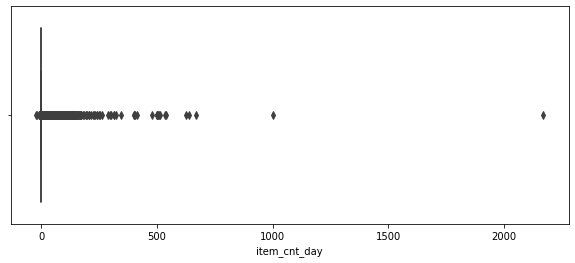

In [4]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_cnt_day)

In [5]:
# remove 2 outliers where items sold in a single day is more than 1000 
train = train[train['item_cnt_day']<1000]

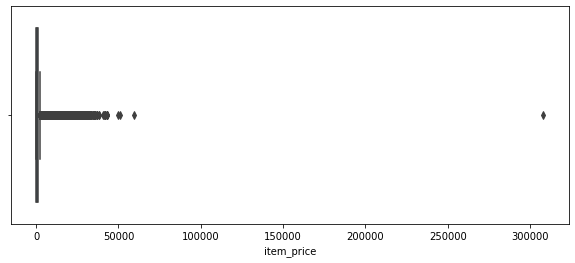

In [6]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_price)

In [7]:
# remove one outlier where items sold in a single day is more than 300,000
train = train[train['item_price']<300000]

## Data Preprocessing

### Price Below 0

In [8]:
train[train['item_price'] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
train.loc[train['item_price'] < 0, 'item_price'] = \
    train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)]\
    .item_price.median()

### Shop Duplication

We will use the SequenceMatcher method to determine the similarilty of each shop name against other shop names. A similarity ratio will be produced. We will examine each case where similar ratios are greater than 0.85. Personal discretion is used to determine if the two shops are the same.

There are two sets of shop names (shop_id = (0,57), (1,58)) where the ending is different by the addition of one word: фран. We will assume this is a location abbreviation and thus the two shops are the same one.  

Although one set is also different by a suffix, Островной. Translation shows that it's Russian for 'island.

shops

In [10]:
from difflib import SequenceMatcher

In [11]:
len_shop= shops.shape[0]

In [12]:
for i in range(len_shop):
    for j in range(i+1, len_shop):
        r = SequenceMatcher(None,shops['shop_name'][i], shops['shop_name'][j]).ratio()
        if  r > .8:
            print('{} {}\n{} {}\n {}\n\n'.format(i, shops['shop_name'][i] ,j, shops['shop_name'][j],r))
        

0 !Якутск Орджоникидзе, 56 фран
57 Якутск Орджоникидзе, 56
 0.8846153846153846


1 !Якутск ТЦ "Центральный" фран
58 Якутск ТЦ "Центральный"
 0.8846153846153846


10 Жуковский ул. Чкалова 39м?
11 Жуковский ул. Чкалова 39м²
 0.9615384615384616


23 Москва ТК "Буденовский" (пав.А2)
24 Москва ТК "Буденовский" (пав.К7)
 0.9375


30 Москва ТЦ "Перловский"
31 Москва ТЦ "Семеновский"
 0.8444444444444444


38 Омск ТЦ "Мега"
54 Химки ТЦ "Мега"
 0.8275862068965517


39 РостовНаДону ТРК "Мегацентр Горизонт"
40 РостовНаДону ТРК "Мегацентр Горизонт" Островной
 0.8809523809523809




In [13]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Extract and encode City from Shop Name
Each shop_name starts with the city name. Some city names are two words, and some have a exclaimation mark in the front which has no meaning. The city name is extracted and coded using LabelEncoder.

In [14]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
shops

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


### Extract and Encode Type and Subtype from Category
Each category contains type and subtype in its name. We will split the item_category_name by '-'. Using LabelEncoder, the first part will be encoded as 'type_code' and the second part will eb encoded as 'subtype_code". Some items may not have a subtype, then the type will fill its place.

In [15]:
cats

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [16]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type_code'] = LabelEncoder().fit_transform(cats['split'].map(lambda x: x[0].strip()))
cats['subtype_code'] = LabelEncoder().fit_transform(cats['split'].map(lambda x: x[-1].strip()))
cats.head()

,item_category_name,item_category_id,split,type_code,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",0,31
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",1,8
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",1,9
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",1,10
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",1,12


In [17]:
cats = cats[['item_category_id','type_code', 'subtype_code']]

### Drop item_name since there is already an item ID

In [18]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [19]:
items.drop(['item_name'], axis=1, inplace=True)

### Monthly Sales

There are 363 new items (with unique id) in the test set. Therefore, for most of the items in the test set the target value should be 0. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [28]:
print('number of unique items in train set, but not test set: ')
print(len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))))

number of unique items in train set, but not test set: 
363


In [22]:
unique_items = len(list(set(test.item_id)))

5100

In [23]:
num_tests = len(test)

214200

We will use the product function from itertools create every possible combination of shop ID and item ID for each date block. There are 34 date blocks in total, so the matrix will have a length of 34. Inside each of the 34 date blocks, a row will be create for each unique shop ID and item ID. Since not all items are sold in every date block, the length (which represents each unique combo of shop ID and item ID) will be different.

In [32]:
matrix = []
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [46]:
len(matrix) # 34 total date_block_num

34

In [47]:
matrix[0].shape 

(365175, 3)

In [48]:
matrix[1].shape

(375728, 3)

Change the matrix into a pandas dataframe. Since all values are integers, change the type to into int8 and int6 to conserve memory.

In [49]:
matrix = pd.DataFrame(np.vstack(matrix), columns=['date_block_num','shop_id','item_id'])
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

Aggregate train set by shop/item pairs to calculate target aggreagates using groupby(). Then, flatten indexes with reset_index() to make columns match those in the matrix created earlier.

Clip(0,20) target value. This way train target will be similar to the test predictions.

```python
numpy.clip(a, a_min, a_max, out=None)
```
Given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.

I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.

In [50]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [59]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [60]:
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [61]:
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','item_id'], how='left')


In [62]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN
...,...,...,...,...
10913799,33,59,22162,NaN
10913800,33,59,22163,NaN
10913801,33,59,22164,NaN
10913802,33,59,22166,NaN


In [63]:
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [64]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


In [67]:
matrix['item_cnt_month'].value_counts()

0.0     9308180
1.0     1058824
2.0      265502
3.0      103227
4.0       53327
5.0       31974
6.0       20731
7.0       14060
20.0      12491
8.0       10430
9.0        7540
10.0       6013
11.0       4483
12.0       3714
13.0       3051
14.0       2448
15.0       2076
16.0       1750
17.0       1577
18.0       1297
19.0       1109
Name: item_cnt_month, dtype: int64

## Test Set

Append test set to the matrix. Set 'date_block_num' = 34.

In [68]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [70]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)

In [71]:
len(matrix)

11128004

In [72]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11127999,34,45,18454,NaN
11128000,34,45,16188,NaN
11128001,34,45,15757,NaN
11128002,34,45,19648,NaN


For the test set added to matrix, item_cnt_month is NaN. We will set it to 0.

In [75]:
matrix.fillna(0, inplace=True)

In [76]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0


## Merge shop, item, and cats features to matrix

In [77]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')

In [78]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,3
1,0,2,27,1.0,0,19,5,9
2,0,2,28,0.0,0,30,8,57
3,0,2,29,0.0,0,23,5,18
4,0,2,32,0.0,0,40,11,3
...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,1
11128000,34,45,16188,0.0,20,64,14,44
11128001,34,45,15757,0.0,20,55,13,1
11128002,34,45,19648,0.0,20,40,11,3


In [79]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

## Target Lags

Given a column, such as item_cnt_month, calculate the shifted date_block_num and merge it back to the dataframe as an extra column, such as item_cnt_month_lag_1.

For example, if we want to add a new column with item_cnt_month_lag_6:
- make a temporary df with the columns date_block_num, shop_id, item_id, and item_cnt_month
- make a shifted df from the temporary df where the item_cnt_month is changed to item_cont_month_6
- the date_block_num becomes date_block_num + 6
- return a new dataframe where the shifted df is joined with the temporary df on date_block_num, shop_id, and item_id

Therefore, we end up with an item_cnt (for the same shop_id and item_id) where it lags behind an X number of date_block_num.

In [82]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [83]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [84]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,3,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,9,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,57,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,18,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,1,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,20,55,13,1,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,20,40,11,3,0.0,0.0,0.0,0.0,NaN


## Mean Encoded Features

### Avg item count by month

In [85]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})

In [88]:
group.tail()

,item_cnt_month
,mean
date_block_num,
30,0.259277
31,0.288086
32,0.263672
33,0.258545
34,0.000000


In [89]:
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

In [90]:
group.tail()

,date_block_num,date_avg_item_cnt
30,30,0.259277
31,31,0.288086
32,32,0.263672
33,33,0.258545
34,34,0.000000


Add the average item count column to the matrix df. Use the lag_feature function created earlier to lag it by one month block.

In [91]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [92]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
11127999,34,45,18454,0.0,20,55,13,1,1.0,0.0,0.0,0.0,NaN,0.258545
11128000,34,45,16188,0.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.258545
11128001,34,45,15757,0.0,20,55,13,1,0.0,0.0,0.0,0.0,0.0,0.258545
11128002,34,45,19648,0.0,20,40,11,3,0.0,0.0,0.0,0.0,NaN,0.258545
11128003,34,45,969,0.0,20,37,11,14,0.0,0.0,0.0,0.0,0.0,0.258545


### Avg item count by item_id

In [93]:
# get average item count by item_id for each date_block_num
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

In [94]:
group.tail()

,date_block_num,item_id,date_item_avg_item_cnt
239006,34,22162,0.0
239007,34,22163,0.0
239008,34,22164,0.0
239009,34,22166,0.0
239010,34,22167,0.0


In [95]:
# add average item count by date_block_num to matrix df
# get 1, 2, 3, 6, and 12 months lag data for average item count and append as colum in matrix
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [97]:
matrix.columns[-5:]

Index(['date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12'],
      dtype='object')

### Avg item count by shop_id

In [98]:
# get average item count by shop_id for each date_block_num
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

In [99]:
# add average item count by date_block_num to matrix df as column
# get 1, 2, 3, 6, and 12 months lag data for average item count and append as colum in matrix
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [100]:
matrix.columns[-5:]

Index(['date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12'],
      dtype='object')

### Avg item count by item_category_id

In [101]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

In [102]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [103]:
matrix.columns[-1]

'date_cat_avg_item_cnt_lag_1'

### Avg item count by shop_id and item_category_id

In [104]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

In [105]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [106]:
matrix.columns[-1]

'date_shop_cat_avg_item_cnt_lag_1'

### Avg item count by shop_id and type_code

In [107]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

In [108]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [109]:
matrix.columns[-1]

'date_shop_type_avg_item_cnt_lag_1'

### Avg item count by shop_id and subtype_code

In [110]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

In [111]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [112]:
matrix.columns[-1]

'date_shop_subtype_avg_item_cnt_lag_1'

### Avg item count by city_code

In [113]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

In [114]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [116]:
matrix.columns[-1]

'date_city_avg_item_cnt_lag_1'

### Avg item count by item_id and city_code

In [117]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

In [118]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [119]:
matrix.columns[-1]

'date_item_city_avg_item_cnt_lag_1'

### Avg item count by type_code

In [120]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

In [121]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [122]:
matrix.columns[-1]

'date_type_avg_item_cnt_lag_1'

### Avg item count by subtype_code

In [123]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

In [124]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [125]:
matrix.columns[-1]

'date_subtype_avg_item_cnt_lag_1'

## Trend Features

In [126]:
# avg item price by id
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

In [127]:
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [128]:
matrix[['item_id','item_avg_item_price']].tail()

,item_id,item_avg_item_price
11127999,18454,188.625
11128000,16188,1257.000
11128001,15757,198.125
11128002,19648,98.125
11128003,969,502.250


In [129]:
# avg item price by date_block and id
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

In [130]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [132]:
matrix[['item_id','date_item_avg_item_price']].head()

,item_id,date_item_avg_item_price
0,19,28.0
1,27,2324.0
2,28,549.0
3,29,2398.0
4,32,338.0


In [134]:
# create columns for average item price for each date block
matrix = lag_feature(matrix, [1,2,3,4,5,6], 'date_item_avg_item_price')

In [145]:
matrix.columns[-6:]

Index(['date_item_avg_item_price_lag_1', 'date_item_avg_item_price_lag_2',
       'date_item_avg_item_price_lag_3', 'date_item_avg_item_price_lag_4',
       'date_item_avg_item_price_lag_5', 'date_item_avg_item_price_lag_6'],
      dtype='object')

In [147]:
matrix.loc[matrix.index[-5:], matrix.columns[-6:]]

,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
11127999,99.000,99.0,99.000,99.0,98.9375,199.000
11128000,1359.000,1223.0,NaN,NaN,NaN,NaN
11128001,229.000,229.0,229.000,229.0,229.0000,208.125
11128002,89.125,99.0,94.875,99.0,99.0000,99.000
11128003,198.000,198.0,198.000,198.0,242.0000,248.000


In [148]:
# for each lag increment: dealta price = [(avg item price lag) - (avg item price)] / (avg item price) 
for i in [1,2,3,4,5,6]:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [149]:
matrix.loc[matrix.index[-5:], matrix.columns[-6:]]

,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6
11127999,-0.475098,-0.475098,-0.475098,-0.475098,-0.475586,0.054993
11128000,0.081116,-0.027054,NaN,NaN,NaN,NaN
11128001,0.155884,0.155884,0.155884,0.155884,0.155884,0.050476
11128002,-0.091736,0.008919,-0.033112,0.008919,0.008919,0.008919
11128003,-0.605957,-0.605957,-0.605957,-0.605957,-0.518066,-0.506348


In [151]:
# select the closest trend with data (not NaN)
def select_trend(row):
    for i in [1,2,3,4,5,6]:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [152]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)

In [153]:
matrix['delta_price_lag'].tail()

11127999   -0.475098
11128000    0.081116
11128001    0.155884
11128002   -0.091736
11128003   -0.605957
Name: delta_price_lag, dtype: float64

In [154]:
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [155]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']

In [156]:
for i in [1,2,3,4,5,6]:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]
matrix.drop(fetures_to_drop, axis=1, inplace=True)

### Last Month's Shop Revenue Trend

In [157]:
# total revenue for each shop_id, by date_block
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

In [158]:
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [160]:
matrix['date_shop_revenue'].head()

0    1085064.75
1    1085064.75
2    1085064.75
3    1085064.75
4    1085064.75
Name: date_shop_revenue, dtype: float32

In [161]:
# average revenue for each shop_id, by date_block
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

In [162]:
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [164]:
matrix['shop_avg_revenue'].head()

0    1295577.625
1    1295577.625
2    1295577.625
3    1295577.625
4    1295577.625
Name: shop_avg_revenue, dtype: float32

In [165]:
# delta revenue
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

In [166]:
matrix = lag_feature(matrix, [1], 'delta_revenue')

In [167]:
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## Special Features

In [169]:
matrix['month'] = matrix['date_block_num'] % 12

In [170]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [174]:
# Remove 12 Month Lag Value
matrix = matrix[matrix.date_block_num > 11]

In [175]:
# fillna for lag values
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [177]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 37 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [178]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# XGBoost

In [179]:
data = pd.read_pickle('data.pkl')

In [183]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
]]

## Train Test Split

Use 13th to 32nd months for training set.
Use 33rd month for validation set.
Use 34th month for test set

In [184]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [185]:
del data
gc.collect();

## Model

In [187]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[21:48:44] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06061	validation_1-rmse:1.06001
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.98441	validation_1-rmse:1.00389
[2]	validation_0-rmse:0.93563	validation_1-rmse:0.97404
[3]	validation_0-rmse:0.90101	validation_1-rmse:0.95045
[4]	validation_0-rmse:0.88423	validation_1-rmse:0.94348
[5]	validation_0-rmse:0.87390	validation_1-rmse:0.93729
[6]	validation_0-rmse:0.86696	validation_1-rmse:0.93608
[7]	validation_0-rmse:0.86218	validation_1-rmse:0.93588
[8]	validation_0-rmse:0.85660	validation_1-rmse:0.93163
[9]	validation_0-rmse:0.85382	validation_1-rmse:0.93323
[10]	validation_0-rmse:0.85103	validation_

1173.233994960785

In [188]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [189]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('sales_submission.csv', index=False)

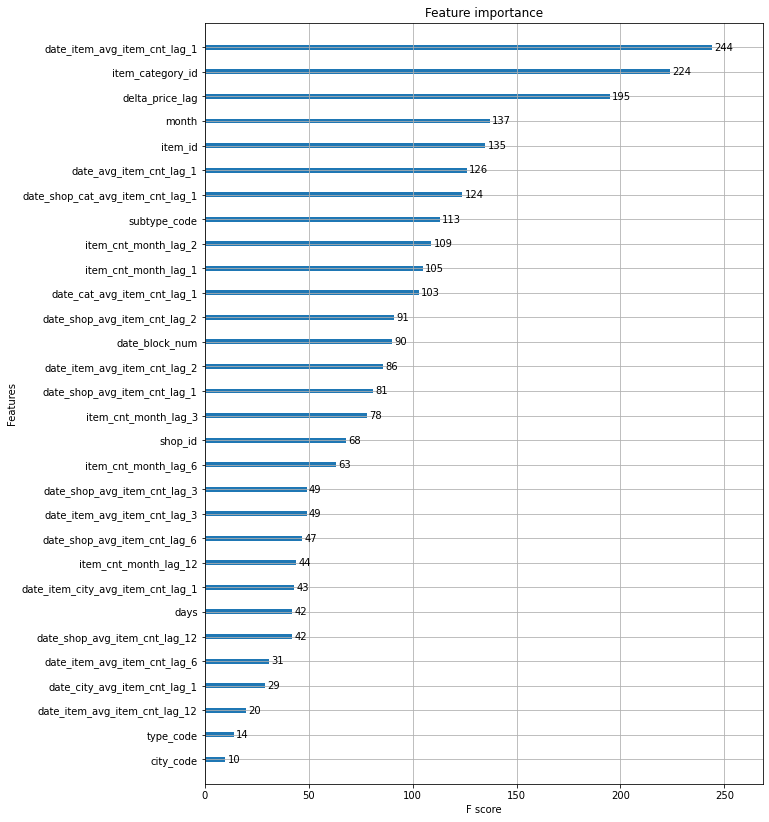

In [190]:
plot_features(model, (10,14))